# Régression linéaire

## Import des packages

In [339]:
#%pip install pandas
#%pip install numpy
#%pip install matplotlib
#%pip install sklearn
%pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import array
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import csv
import datetime
import itertools
import pickle
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

- Chargement des données

In [341]:
def load_data(name):
    df = pd.read_csv(name)
    return df

- préparation (filtrage) des colonnes

In [342]:
def prepare_data(df):
    columns=[]
    columns_category=[]
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            #print(f"La colonne '{col}' est numérique.")
            columns.append(col)
        else:
            #print(f"La colonne '{col}' n'est pas numérique.")
            columns_category.append(col)
    
    df_numeric = df[columns].astype(float)
    df_category = df[columns_category]
    return df_category, df_numeric

- transformation des catégories

In [343]:
def transform_data(data):
    encoder = OneHotEncoder()
    for col in data.columns:
        one_hot_array = encoder.fit_transform(data[[col]]).toarray()
        one_hot_df = pd.DataFrame(one_hot_array, columns = encoder.get_feature_names_out(), index = data.index)
        if col not in ("region","age_group","bmi_category"):
            data = pd.concat([data, one_hot_df.iloc[:,0]], axis=1).drop([col], axis=1)
        else:
            data = pd.concat([data, one_hot_df], axis=1).drop([col], axis=1)    
    return data           

- la normalisation (centrage et réduction)

In [344]:
def normalize_data(data, normalisation_code):
    """
    Normalise les données selon le code fourni.
    
    Args:
        data (pd.DataFrame): Données à normaliser.
        normalisation_code (int): Code de normalisation.
            - 0 : Standardisation manuelle (z-score).
            - 1 : StandardScaler.
            - 2 : MinMaxScaler.
    
    Returns:
        pd.DataFrame: Données normalisées.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Les données doivent être un DataFrame Pandas.")
    
    if normalisation_code not in [0, 1, 2]:
        raise ValueError("Code de normalisation invalide. Utiliser 0, 1 ou 2.")
    
    if normalisation_code == 0:
        # Normalisation manuelle (z-score)
        for i in range(data.shape[1]):
            mu = data.iloc[:, i].mean()
            std = data.iloc[:, i].std()
            if std != 0:  # Éviter la division par zéro
                data.iloc[:, i] = (data.iloc[:, i] - mu) / std
            else:
                data.iloc[:, i] = 0  # Si la colonne est constante, tous les z-scores sont 0
    else:
        # Normalisation avec Scikit-learn
        if normalisation_code in [1, 2]:
            scaler = StandardScaler() if normalisation_code == 1 else MinMaxScaler()
            data_scaled = scaler.fit_transform(data)
            data = pd.DataFrame(data_scaled, columns=data.columns)
    
    return data


. calcul performance

In [345]:
def calcul_Performane(y_test, y_pred):
        # Évaluation du modèle
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return r2

- Affichage

In [346]:
def plot_performance(J_all, num_epochs):
	plt.xlabel('Modeles')
	plt.ylabel('R2')
	#plt.scatter(num_epochs, J_all,c ='red', marker = 'o' )
	plt.plot(num_epochs, J_all, 'm', linewidth = "1")
	plt.plot
	plt.show()

- modélisation des données

In [347]:
def model_data(data_X, data_cible_y, num_model):
    
    # Division des données en ensembles d'apprentissage et de test
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_cible_y, shuffle=True, train_size=0.85, random_state=42, stratify=data_X['smoker_no'])

    # Modèle basé sur la moyenne (DummyRegressor)
    if num_model == 0:
        model = DummyRegressor(strategy='mean')
        model.fit(X_train, y_train)   
    elif num_model == 1:
        model = LinearRegression().fit(X_train, y_train)
    elif num_model == 2:
        model = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)
    elif num_model == 3:
        model = Ridge(alpha=0.1).fit(X_train, y_train)
    else:
        model = ElasticNet(random_state=0).fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = calcul_Performane(y_test, y_pred)
    return r2


In [348]:
def RRF(data_X, data_cible_y): 

    X_train, X_test, y_train, y_test =   train_test_split(data_X, data_cible_y, shuffle=True, train_size=0.85, random_state=42, stratify=data_X['smoker_no'])
    #train_test_split(data_X, data_cible_y, test_size=0.2, random_state=42)
    
    # Régression linéaire avec PolynomialFeatures
    poly = PolynomialFeatures(degree=2, include_bias=True)
    #scaler = StandardScaler()
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Modèle régression linéaire
    linear_model = LinearRegression()
    linear_model.fit(X_train_poly, y_train)
    y_pred_linear = linear_model.predict(X_test_poly)
    return(r2_score(y_test, y_pred_linear))

## Main Function

In [349]:
df = load_data("df_assurance_clean_with_log_v4_with_new_val_7.csv")

print(df.info())
df_category, df_numeric = prepare_data(df)
df_cible = df_numeric.iloc[:,-1]
df_numeric = df_numeric[df_numeric.columns[:-1]]

df_category_transforme = transform_data(df_category)

model_dict ={
      0:'DummyRegr',
      1:'LinearReg',
      2:'Lasso',
      3:'Ridge',
      4:'ElasticNet',
             }

combined_df = pd.concat([df_numeric, df_category_transforme], axis=1)

columns = combined_df.columns

performances=[]
n_epochs = []
count = 0

date_now = datetime.datetime.today()
# Reformater la date pour éviter les caractères spéciaux
formatted_date = date_now.strftime("%Y-%m-%d_%H-%M-%S")
file_name = "results_RL_Norm1_" + formatted_date + ".csv"

Selection = False

with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["i", "j", "k", "l", "result"])  # En-têtes
                    
    if Selection : 
        for r in range(1, len(columns) + 1):  # Longueur des combinaisons, de 1 à nombre de colonnes
            combinaisons = list(itertools.combinations(columns, r))
            #print(combinaisons)
            for combinaison in combinaisons:
                df_subset = combined_df[list(combinaison)]  # Sous-ensemble du DataFrame
                
                #for normalisation in range(3):# on utilise qu'une méthode de normalisation pour le moment
                #    df_subset_normalizes = normalize_data(df_subset, normalisation)
                df_subset_normalizes = normalize_data(df_subset, 1)


                    #for methode_modelisation in range(6):#:# on utilise que deux méthode de modélisation linéaire pour le moment
                resultat = RRF(df_subset_normalizes, df_cible)
                performances.append(resultat)
                n_epochs.append(count)
                count +=1
                writer.writerow([r, combinaison, 1, 6, resultat])
        
        plot_performance(performances, n_epochs )

    else:
        combined_df_normalizes = normalize_data(combined_df, 1)
        resultat = RRF(combined_df_normalizes, df_cible)
        writer.writerow(['All','ALL', 1, 'RFF', resultat])
        print("performances R2: ", resultat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex           1337 non-null   object 
 1   children      1337 non-null   int64  
 2   smoker        1337 non-null   object 
 3   region        1337 non-null   object 
 4   age_bmi       1337 non-null   float64
 5   age_group     1337 non-null   object 
 6   bmi_category  1337 non-null   object 
 7   bmi_smoker    1337 non-null   float64
 8   age_smoker    1337 non-null   int64  
 9   log_age       1337 non-null   float64
 10  log_charges   1337 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 115.0+ KB
None
performances R2:  0.8716468511947745


. Utilisation de PolynomialFeatures pour améliorer les performances

In [350]:
# Chargement des données
#('age', 'bmi', 'children', 'smoker_no', 'region_northwest', 'region_southeast', 'region_southwest')
#combined_df_selection = combined_df[['age', 'bmi', 'children', 'smoker_no', 'region_northwest', 'region_southeast', 'region_southwest']]
#print(combined_df_selection.info)
combined_df = normalize_data(combined_df, 1)
X_train, X_test, y_train, y_test = train_test_split(combined_df, df_cible, shuffle=True, train_size=0.85, random_state=42, stratify=combined_df['smoker_no'])
#train_test_split(combined_df, df_cible, test_size=0.2, random_state=42)


# Régression linéaire avec PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=True)
#scaler = StandardScaler()
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Modèle régression linéaire
linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)
y_pred_linear = linear_model.predict(X_test_poly)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Régression linéaire R2: {r2_linear:.3f}")


Régression linéaire R2: 0.872


. Utilisation des pipelines

In [351]:
numeric_features = ['children','bmi_smoker','age_smoker','age_bmi','log_age']#'age', 'bmi', ,'log_children'
categorical_features = ['sex','smoker']
ordinal_features = ['region','age_group','bmi_category']

df_cible = df.iloc[:,-1]
df_numeric = df[df.columns[:-1]]
# Chargement des données
X_train, X_test, y_train, y_test = train_test_split(df_numeric, df_cible, shuffle=True, train_size=0.85, random_state=42, stratify=df_numeric['smoker'])
#(df_numeric, df_cible, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalisation des données numériques
        ('cat', OneHotEncoder(drop='first'), categorical_features),  # Encodage des variables catégoriques
        ('ord', OrdinalEncoder(), ordinal_features)
    ], remainder='passthrough',
    )
#print(preprocessor)
# Création d'un pipeline avec prétraitement et modèle
# Régression linéaire
lr_model = make_pipeline(preprocessor, PolynomialFeatures(2,include_bias=True), LinearRegression())
lr_model.fit(X_train, y_train)

"""score_ = []
state_ = []
for i in range(1000):
    X_train_, X_test_, y_train_, y_test_  = train_test_split(df_numeric, df_cible, test_size=0.2, random_state=i)
    clf_ = make_pipeline(preprocessor, PolynomialFeatures(2,), LinearRegression())
    clf_.fit(X_train_, y_train_)
    y_pred_ = clf_.predict(X_test_)
    score_.append(r2_score(y_test_, y_pred_))
    state_.append(i)
plot_performance(score_, state_)"""

'score_ = []\nstate_ = []\nfor i in range(1000):\n    X_train_, X_test_, y_train_, y_test_  = train_test_split(df_numeric, df_cible, test_size=0.2, random_state=i)\n    clf_ = make_pipeline(preprocessor, PolynomialFeatures(2,), LinearRegression())\n    clf_.fit(X_train_, y_train_)\n    y_pred_ = clf_.predict(X_test_)\n    score_.append(r2_score(y_test_, y_pred_))\n    state_.append(i)\nplot_performance(score_, state_)'

In [352]:
# Prédictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
mse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Affichage des résultats
print("\nRésultats Régression Linéaire après Normalisation")
print("MSE :", mse_lr)
print("R² :", r2_lr)


Résultats Régression Linéaire après Normalisation
MSE : 0.26394812418767055
R² : 0.9182986179495953


# Enregistrement du modèle en format.pkl

In [353]:
with open('linear_regression_model_1.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

In [354]:
def affichage_performance(results):
    methods = list(results.keys())
    mse_values = [results[method]['MSE'] for method in methods]
    r2_values = [results[method]['R2'] for method in methods]
    training_times = [results[method]['Training Time (s)'] for method in methods]

    # Créer une figure avec deux axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Axe 1 pour MSE et R²
    ax1.set_title("Performances et Temps d'Apprentissage des Modèles")
    ax1.set_xlabel("Méthodes")
    ax1.set_ylabel("MSE / R²", color='tab:blue')

    # Barres pour MSE
    width = 0.35  # Largeur des barres
    x = np.arange(len(methods))
    bar_mse = ax1.bar(x - width/2, mse_values, width, label='MSE', color='tab:blue', alpha=0.7)

    # Ligne pour R²
    line_r2 = ax1.plot(x, r2_values, marker='o', label='R²', color='tab:cyan')

    # Ajouter les valeurs au-dessus des barres
    for i, v in enumerate(mse_values):
        ax1.text(x[i] - width/2, v + 0.1, f"{v:.2f}", ha='center', color='blue', fontsize=9)

    for i, v in enumerate(r2_values):
        ax1.text(x[i], v + 0.01, f"{v:.2f}", ha='center', color='cyan', fontsize=9)

    ax1.legend(loc='upper left')

    # Axe 2 pour le temps d'apprentissage
    ax2 = ax1.twinx()
    ax2.set_ylabel("Temps d'Apprentissage (s)", color='tab:red')

    # Barres pour les temps d'apprentissage
    bar_time = ax2.bar(x + width/2, training_times, width, label='Temps', color='tab:red', alpha=0.7)

    # Ajouter les valeurs au-dessus des barres
    for i, v in enumerate(training_times):
        ax2.text(x[i] + width/2, v + 0.001, f"{v:.3f}s", ha='center', color='red', fontsize=9)

    ax2.legend(loc='upper right')

    # Ajouter les labels sur l'axe x
    plt.xticks(x, methods)

    # Afficher le graphique
    plt.tight_layout()
    plt.show()

In [355]:
import time


df_cible = df.iloc[:,-1]
df_numeric = df[df.columns[:-1]]
# Chargement des données
X_train, X_test, y_train, y_test = train_test_split(df_numeric, df_cible, shuffle=True, train_size=0.85, random_state=42, stratify=df_numeric['smoker'])

#train_test_split(df_numeric, df_cible, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalisation des données numériques
        ('cat', OneHotEncoder(drop='first'), categorical_features),  # Encodage des variables catégoriques
        ('ord', OrdinalEncoder(), ordinal_features)
    ], remainder='passthrough',
    )

# Modèles à tester
models = {
    #'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

# Ajout de caractéristiques polynomiales
polynomial_preprocessor = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=True))
])

# Hyperparamètres pour optimisation
param_grid = {
    'Ridge': {'model__alpha': [0.15, 0.2, 10]},
    'Lasso': {'model__alpha': [0.09, 0.15, 10] },
    'ElasticNet': {
        'model__alpha': [0.1, 1.0, 20.0],
        'model__l1_ratio': [0.1, 0.5, 0.9]
    }
}

# Résultats
results = {}

# Entraîner et évaluer chaque modèle
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    start_time = time.time()  # Démarrer le timer
    # Choix de la préprocessing
    if model_name == 'LinearRegression':
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('preprocessor', polynomial_preprocessor),
            ('model', model)
        ])
    
    if model_name in param_grid:
        # Optimisation des hyperparamètres avec GridSearchCV
        search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='r2')
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        # Pas d'optimisation pour la régression linéaire
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = None

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Évaluation
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {
        'MSE': mse,
        'R2': r2,
        'Best Params': best_params,
        'Training Time (s)': elapsed_time
    }

    """residuals = y_test - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, color="blue", alpha=0.7)
    plt.axhline(y=0, color="red", linestyle="--", linewidth=1)  # Ligne centrale (résidu = 0)
    plt.title("Graphe des résidus")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=20, color="blue", alpha=0.7)
    plt.title("Distribution des résidus")
    plt.xlabel("Résidus")
    plt.ylabel("Fréquence")
    plt.grid(alpha=0.3)
    plt.show()

    from scipy.stats import shapiro
    
    stat, p_value = shapiro(residuals)
    print("Statistique de test Shapiro-Wilk :", stat)
    print("p-value :", p_value)

    if p_value > 0.05:
        print("Les résidus semblent suivre une distribution normale.")
    else:
        print("Les résidus ne suivent pas une distribution normale.")
    results[model_name] = {
        'MSE': mse,
        'R2': r2,
        'Best Params': best_params
    }"""

# Afficher les résultats
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f" - MSE: {metrics['MSE']}")
    print(f" - R2: {metrics['R2']}")
    print(f" - Training Time: {metrics['Training Time (s)']:.2f} seconds")
    if metrics['Best Params']:
        print(f" - Best Params: {metrics['Best Params']}")



Training Ridge...
Training Lasso...
Training ElasticNet...

Model: Ridge
 - MSE: 0.06941039160103851
 - R2: 0.9186014370270107
 - Training Time: 0.87 seconds
 - Best Params: {'model__alpha': 10}

Model: Lasso
 - MSE: 0.16383902583294124
 - R2: 0.8078636216555166
 - Training Time: 0.59 seconds
 - Best Params: {'model__alpha': 0.09}

Model: ElasticNet
 - MSE: 0.07895698121248937
 - R2: 0.9074060142993663
 - Training Time: 1.57 seconds
 - Best Params: {'model__alpha': 0.1, 'model__l1_ratio': 0.1}


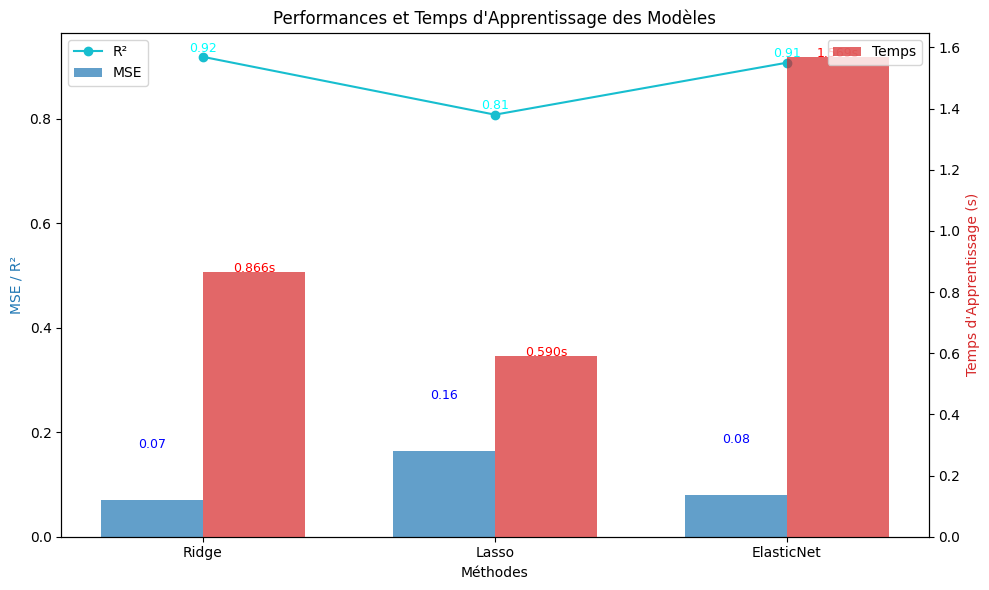

In [356]:
affichage_performance(results)

In [357]:
results_withoutoutliers =results
df_results = pd.DataFrame.from_dict(results_withoutoutliers, orient='index')

# Sauvegarder dans un fichier CSV
df_results.to_csv('model_performances_withoutoutliers.csv', index_label='Model')

print("Performances sauvegardées dans 'model_performances_withoutoutliers.csv'")

Performances sauvegardées dans 'model_performances_withoutoutliers.csv'


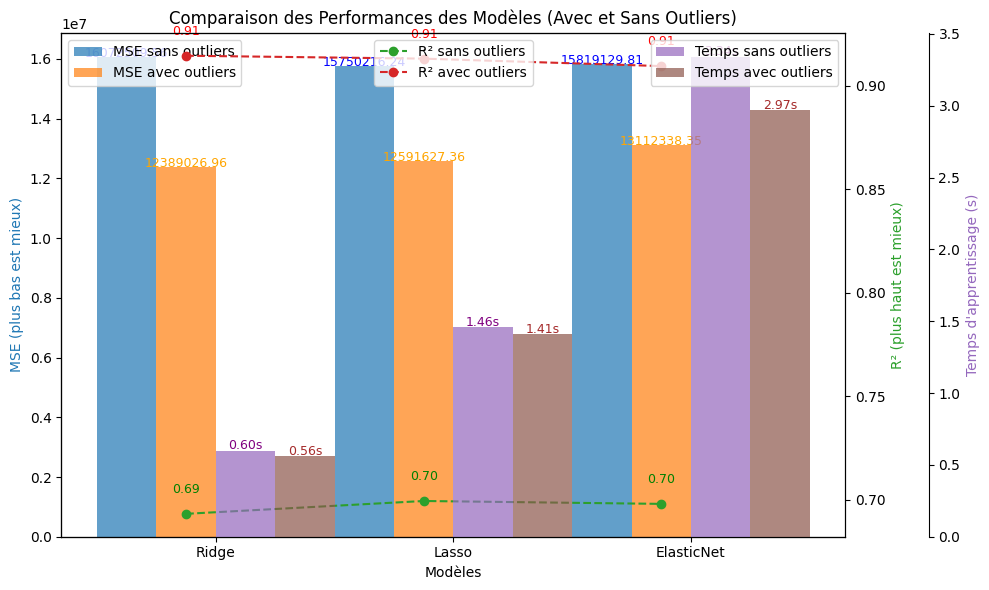

In [358]:
# Performances sans outliers
results_without_outliers = {
    'Ridge': {'MSE': 16072509.56, 'R2': 0.6932, 'Training Time (s)': 0.60},
    'Lasso': {'MSE': 15750216.24, 'R2': 0.6994, 'Training Time (s)': 1.46},
    'ElasticNet': {'MSE': 15819129.81, 'R2': 0.6980, 'Training Time (s)': 3.34},
}

# Performances avec outliers
results_with_outliers = {
    'Ridge': {'MSE': 12389026.96, 'R2': 0.9145, 'Training Time (s)': 0.56},
    'Lasso': {'MSE': 12591627.36, 'R2': 0.9131, 'Training Time (s)': 1.41},
    'ElasticNet': {'MSE': 13112338.35, 'R2': 0.9095, 'Training Time (s)': 2.97},
}

# Extraire les noms des modèles
models = list(results_without_outliers.keys())

# Extraire les valeurs de MSE, R2 et Temps d'apprentissage
mse_without = [results_without_outliers[model]['MSE'] for model in models]
r2_without = [results_without_outliers[model]['R2'] for model in models]
time_without = [results_without_outliers[model]['Training Time (s)'] for model in models]

mse_with = [results_with_outliers[model]['MSE'] for model in models]
r2_with = [results_with_outliers[model]['R2'] for model in models]
time_with = [results_with_outliers[model]['Training Time (s)'] for model in models]

# Création d'un graphique à barres
x = np.arange(len(models))  # positions sur l'axe x
width = 0.25  # largeur des barres

# Créer un graphique avec plusieurs axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barres pour MSE sans et avec outliers
ax1.bar(x - width, mse_without, width, label='MSE sans outliers', color='tab:blue', alpha=0.7)
ax1.bar(x, mse_with, width, label='MSE avec outliers', color='tab:orange', alpha=0.7)

# Barres pour R² sans et avec outliers
ax2 = ax1.twinx()  # Créer un deuxième axe y pour R²
ax2.plot(x, r2_without, marker='o', label='R² sans outliers', color='tab:green', linestyle='--')
ax2.plot(x, r2_with, marker='o', label='R² avec outliers', color='tab:red', linestyle='--')

# Barres pour le temps d'apprentissage
ax3 = ax1.twinx()  # Créer un troisième axe y pour le temps
ax3.spines['right'].set_position(('outward', 60))  # Décaler le troisième axe y
ax3.bar(x + width, time_without, width, label='Temps sans outliers', color='tab:purple', alpha=0.7)
ax3.bar(x + 2*width, time_with, width, label='Temps avec outliers', color='tab:brown', alpha=0.7)

# Configuration des légendes et titres
ax1.set_title("Comparaison des Performances des Modèles (Avec et Sans Outliers)")
ax1.set_xlabel("Modèles")
ax1.set_ylabel("MSE (plus bas est mieux)", color='tab:blue')
ax2.set_ylabel("R² (plus haut est mieux)", color='tab:green')
ax3.set_ylabel("Temps d'apprentissage (s)", color='tab:purple')

# Configurer les positions des axes et les étiquettes
ax1.set_xticks(x + width / 2)
ax1.set_xticklabels(models)

# Ajouter les légendes
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')

# Ajouter les valeurs au-dessus des barres
for i, v in enumerate(mse_without):
    ax1.text(x[i] - width, v + 0.1, f"{v:.2f}", ha='center', color='blue', fontsize=9)
for i, v in enumerate(mse_with):
    ax1.text(x[i], v + 0.1, f"{v:.2f}", ha='center', color='orange', fontsize=9)
for i, v in enumerate(r2_without):
    ax2.text(x[i], v + 0.01, f"{v:.2f}", ha='center', color='green', fontsize=9)
for i, v in enumerate(r2_with):
    ax2.text(x[i], v + 0.01, f"{v:.2f}", ha='center', color='red', fontsize=9)
for i, v in enumerate(time_without):
    ax3.text(x[i] + width, v + 0.01, f"{v:.2f}s", ha='center', color='purple', fontsize=9)
for i, v in enumerate(time_with):
    ax3.text(x[i] + 2*width, v + 0.01, f"{v:.2f}s", ha='center', color='brown', fontsize=9)

# Afficher le graphique
plt.tight_layout()
plt.show()